## Interpolate Eulerian mean velocity fields over drifters trajectories

In [1]:
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pyinterp
import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5177406.datarmor0/parcels-502090/libparcels_random_4df1e235-b915-45a5-9e68-155f3b6b49e1.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=10
                 )
#
client = Client(cluster)


In [3]:
client

Client Scheduler: tcp://10.148.1.75:48644 Dashboard: http://10.148.1.75:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load data : Eulerian mean field

In [4]:
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean"]#, "mean_square"]
ds = xr.merge([ut.load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

In [4]:
grd = ut.load_grd(V=['XC','YC','CS','SN'])
ds = xr.merge([grd,ds])

In [5]:
ds.load()
#ds = ds.persist()

<xarray.Dataset>
Dimensions:   (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
    XC        (face, j, i) float32 -114.9 -114.9 -114.9 ... -114.7 -114.8 -114.9
    YC        (face, j, i) float32 -88.18 -88.18 -88.18 ... -88.17 -88.17 -88.17
    CS        (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SN        (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j         (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mean_Eta  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSU  (face, j, i_g) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSV  (face, j_g, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SST  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSS  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan

In [6]:
# Rotation velocity field
U_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.CS - ds.mean_SSV.rename({'j_g': 'j'})*ds.SN
V_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.SN + ds.mean_SSV.rename({'j_g': 'j'})*ds.CS

U_mean['lon'] = 0*ds.face+ds.XC
U_mean['lat'] = 0*ds.face+ds.YC

V_mean['lon'] = 0*ds.face+ds.XC
V_mean['lat'] = 0*ds.face+ds.YC

In [7]:
# Mean Eulerian field Dataset
ds_mean = xr.Dataset({'meridional_velocity_mean':V_mean,'zonal_velocity_mean':U_mean,
                      'sea_level_mean':ds.mean_Eta,'temperature_mean':ds.mean_SST,'salinity_mean':ds.mean_SSS})

### Test of interpolation method on LLC4320 grid (increase resolution)

In [8]:
mesh = pyinterp.RTree()

In [27]:
# Subsampling the grid (simulate a lower spatial resolution)
sli = slice(0,None,50)

In [30]:
#Packing of the mean field on the llc4320 grid
V = 'zonal_velocity_mean'
mesh.packing(
    np.vstack((ds_mean[V].lon.isel(i=sli,j=sli).values.flatten(), ds_mean[V].lat.isel(i=sli,j=sli).values.flatten())).T,
    ds_mean[V].isel(i=sli,j=sli).values.flatten())

In [31]:
#Definition of the points for which field should be interpolated

x0,x1 = np.around(ds_mean[V].lon.values.min()),np.around(ds_mean[V].lon.values.max())
y0,y1 = np.around(ds_mean[V].lat.values.min()),np.around(ds_mean[V].lat.values.max())
res = 1 / 32.0
mx, my = np.meshgrid(np.arange(x0, x1, res),
                        np.arange(y0, y1, res),
                        indexing="ij")

#### First implemented interpolation method in pyinterp : 
Inverse distance weighted (the weight use for the interpolation is the inverse of the distance)



In [59]:
idw_eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    radius=None,#55000,  # In a radius of 5.5 Km
    k=8,  # We are looking for at most 8 neighbours
    num_threads=0)

#### Second implemented interpolation method in pyinterp :
Radial basis function (the weight follows a chosen function depending on the distance between points), default (used here) is multiquadratic function : $\sqrt{1+r^2/\epsilon^2}$

In [33]:
rbf_eta, neighbors = mesh.radial_basis_function(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbours
    num_threads=0)

In [60]:
idw_eta = idw_eta.reshape(mx.shape)
rbf_eta = rbf_eta.reshape(mx.shape)

In [61]:
ds_interp = xr.Dataset(data_vars={'idw':(['lon','lat'],idw_eta),'rbf':(['lon','lat'],rbf_eta)},coords={'lon':mx[:,0],'lat':my[0,:]})

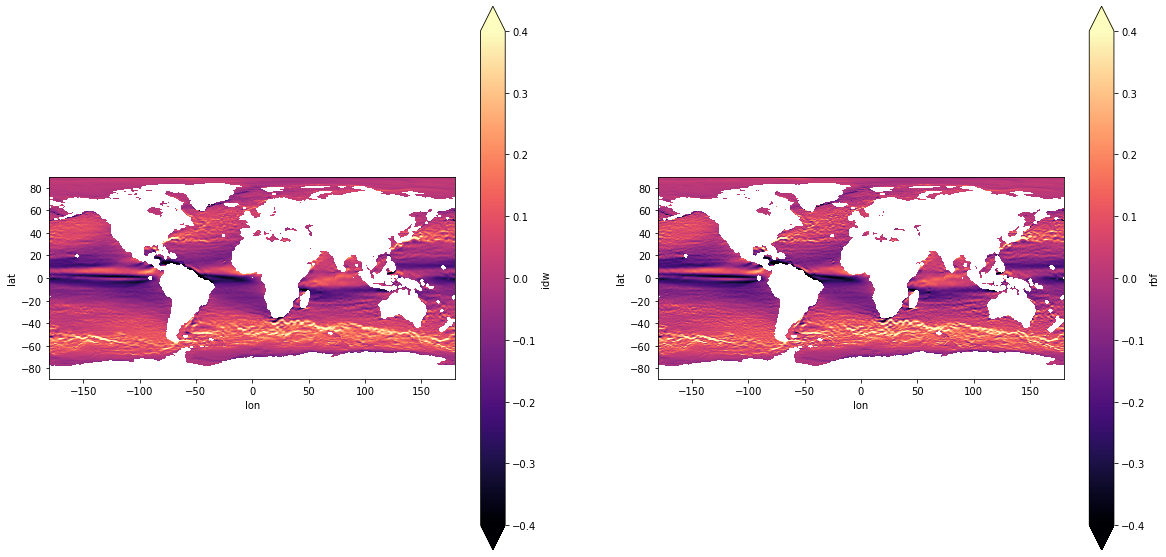

In [66]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ds_interp.idw.plot(ax=ax[0],y='lat',cmap='magma',vmin=-0.4,vmax=0.4)
ds_interp.rbf.plot(ax=ax[1],y='lat',cmap='magma',vmin=-0.4,vmax=0.4)
ax[0].set_aspect('equal');ax[1].set_aspect('equal')

#### Notes:
Similar results using both interpolation method.

NB : it was necessary to set radius=None in IDW method as the results were unsatifactory with default radius 55000 (gaps at low latitudes).

(<Figure size 432x288 with 12 Axes>,
 array([[<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='y-dimension of the t grid'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='y-dimension of the t grid'>,
         <AxesSubplot:xlabel='y-dimension of the t grid', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='y-dimension of the t grid', ylabel='x-dimension of the t grid'>],
        [<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='y-dimension of the t grid'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='y-dimension of the t grid'>,
         <AxesSubplot:xlabel='y-dimension of the t grid', ylabel='x-dimension of the t grid'>,
         <AxesSubplot:xlabel='y-dimension of the t grid', ylabel='x-dimension of the t grid'>],
        [<AxesSubplot:xlabel='x-dimension of the t grid', ylabel='y-dimension of the t grid'>,
         <AxesSubplot:xlabel='x-dimension of the t grid', ylabel='y-dimension of the t grid'>,
         <A

<Figure size 720x720 with 0 Axes>

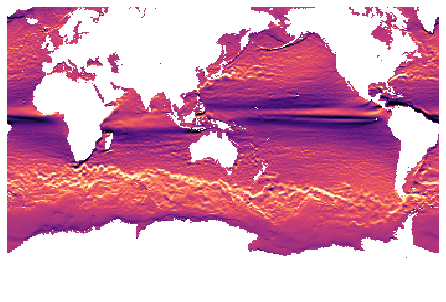

In [71]:
#Plot global ean of meridional velocity on LLC4320 grid (with lower resolution : 1/50 points)
plt.figure(figsize=(10,10))
quick_llc_plot(ds_mean[V].isel(i=sli,j=sli), vmin=-0.4, vmax=0.4, 
               add_colorbar=False, axis_off=True,cmap='magma')


### Load Lagrangian data

In [4]:
#root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
#run_name = 'global_extra_T365j_dt1j_dij50'
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
df = p.df['trajectory']
df.head()

,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
trajectory,,,,,,,,,
39000000,2011-11-15,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
39000001,2011-11-15,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
39000002,2011-11-15,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
39000003,2011-11-15,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
39000004,2011-11-15,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
p_interp = pa.parcels_output(root_dir+run_name, parquets=['trajectory_mean'])
df_interp = p_interp.df['trajectory_mean']
df_interp.head()

,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp
trajectory,,,,,,,,,,,,,,
39000000,2011-11-15,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,0.060997,-0.002461,4.279537,-0.006017,33.194778
39000001,2011-11-15,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,0.075155,-0.091730,4.326020,0.050204,33.139637
39000002,2011-11-15,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,0.169278,-0.203138,4.161501,0.209887,32.961617
39000003,2011-11-15,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,0.242839,-0.075768,3.679666,0.064889,32.712219
39000004,2011-11-15,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,0.222071,-0.006189,3.151162,0.057710,32.573410


### Interpolation of Eulerian mean field

In [6]:
df_interp = df_interp.persist()

In [5]:
# We had to compute the interpolation separating the dataset in two, otherwies problems occured

n_part = 10*7
df = dd.concat([df.get_partition(n) for n in range(0,int(n_part*2))])
df = df.repartition(npartitions=n_part) #Repartition to have one partition by worker
df = df.persist()

In [7]:
def interp_trajectories(df_sub,v):
    """
    Interpolate Eulerian mean field over simulated drifters trajectories usin inverse distance weigthing method.
    
    Parameters:
    ----------
    df_sub : dask dataframe
    v : Variable to be interpolated
    Returns:
    ----------
    df_sub : input dask dataframe with an additional column of interpolated field
    """     
    grd = ut.load_grd(V=['XC','YC','CS','SN'])
    if np.isin(v,['SSU','SSV']):
        ds = xr.merge([ut.load_diagnostic("mean_"+V) for V in ['SSU','SSV']])
        ds = xr.merge([grd, ds])
        ds = ds.isel(i=slice(0,None, 2), j=slice(0,None, 2))
        U_mean =  ds.SSU.rename({'i_g':'i'})*ds.CS - ds.SSV.rename({'j_g':'j'})*ds.SN
        V_mean =  ds.SSU.rename({'i_g':'i'})*ds.SN + ds.SSV.rename({'j_g':'j'})*ds.CS
        ds['SSU'] = U_mean
        ds['SSV'] = V_mean
        ds = xr.merge([ds[V] for V in ['SSU','SSV']]).compute()
    else :
        ds = ut.load_diagnostic("mean_"+v)
        ds = xr.merge([grd, ds])
        ds = ds.isel(i=slice(0,None, 2), j=slice(0,None, 2))
        ds = ds.compute()
        #ds.load()
    mesh = pyinterp.RTree()
    
    mesh.packing(np.vstack((ds.XC.values.flatten(), 
                            ds.YC.values.flatten())).T,
                 ds[v].values.flatten(),
                )
    
    idw_eta, neighbors = mesh.inverse_distance_weighting(
        np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
        within=True,
        radius=55000,
        k=8,  
        num_threads=0)
    
    df_sub[v+'_interp'] = idw_eta

    return  df_sub

### Interpolation over all trajectories : 

In [7]:
v = 'Eta'
df_interp = df.map_partitions(interp_trajectories,v).persist()
#meta.update({'SSV'+'_interp':'float32'})
#df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [12]:
v = ['SSS']
for V in v:
    df_interp = df_interp.map_partitions(interp_trajectories,V).persist()

In [11]:
df_interp.std().compute()

lat                    4.350941e+01
lon                    1.041280e+02
z                      0.000000e+00
zonal_velocity         3.581037e-06
meridional_velocity    1.971748e-06
sea_level              9.184727e-01
temperature            7.892704e+00
salinity               1.997921e+00
Eta_interp             6.819402e-01
SSU_interp             1.158468e-01
SST_interp             2.652063e+29
SSV_interp             8.442507e-02
dtype: float64

In [8]:
# Second part of the dataframe
n_part = 10*7
df = p.df['trajectory']
df = dd.concat([df.get_partition(n) for n in range(n_part*2,2*n_part*2)])
#df = dd.concat([df.get_partition(n) for n in range(2*n_part*2,377)])
df = df.repartition(npartitions=n_part)
df = df.persist()

In [9]:
v = 'Eta'
df_interp_bis = df.map_partitions(interp_trajectories,v).persist()

In [10]:
v = 'SSU'
df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [11]:
v = 'SST'
df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [12]:
v = 'SSV'
df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [ ]:
v = 'SSS'
df_interp_bis = df_interp_bis.map_partitions(interp_trajectories,v).persist()

In [14]:
df_interp = df_interp.append(df_interp_bis).persist()

In [13]:
df_interp.std().compute()

lat                    4.472499e+01
lon                    1.177652e+02
z                      0.000000e+00
zonal_velocity         3.257365e-06
meridional_velocity    1.834151e-06
sea_level              1.026319e+00
temperature            1.010312e+01
salinity               1.807843e+00
Eta_interp             8.621572e-01
SSU_interp             1.154602e-01
SST_interp             1.875108e+29
SSV_interp             7.895490e-02
SSS_interp             3.259267e+26
dtype: float64

In [15]:
df_interp = df_interp.rename(columns={'SSU_interp':'mean_zonal_velocity','SSV_interp':'mean_meridional_velocity',
                              'Eta_interp':'mean_sea_level','SSS_interp':'mean_salinity','SST_interp':'mean_temperature'})

In [19]:
df_interp

,time,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp
npartitions=70,,,,,,,,,,,,,,
,datetime64[ns],float64,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_interp, overwrite=True, name="trajectory_mean")

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/trajectory_mean
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/trajectory_mean


'/home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/trajectory_mean'

### Load interpolated dataframe

In [3]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])
df = df = p.df['time_mean']

df = pa.degs2ms(df) #Convert in m/s 
#df = df.repartition(npartitions=100)
df = df.persist()

### Visualization interpolation one trajectory : 

In [4]:
df_tst = df.groupby('trajectory').get_group(4000125).compute()


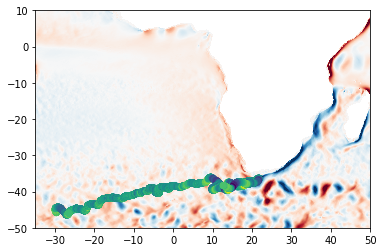

In [29]:
#Visualization trajectory with Eulerian mean field in the background

plt.pcolormesh(ds_mean['meridional_velocity_mean'].lon.isel(face=1),
               ds_mean['meridional_velocity_mean'].lat.isel(face=1),
               ds_mean['meridional_velocity_mean'].isel(face=1),cmap='RdBu_r',vmin=-0.5,vmax=0.5)
plt.ylim(-50,10);plt.xlim(-35,50)
plt.scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity)

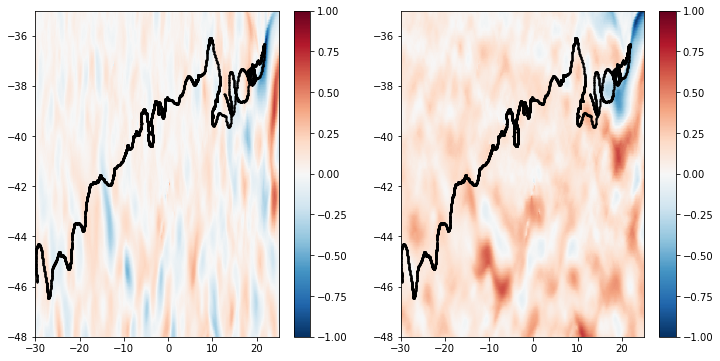

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].pcolormesh(ds.lon.isel(face=1),ds.lat.isel(face=1),V_mean.isel(face=1),cmap='RdBu_r',vmin=-1,vmax=1)
cs1 = ax[1].pcolormesh(ds.lon.isel(face=1),ds.lat.isel(face=1),U_mean.isel(face=1),cmap='RdBu_r',vmin=-1,vmax=1)
for a in ax:
    a.set_ylim(-48,-35);a.set_xlim(-30,25)
    a.scatter(df_tst.lon,df_tst.lat,s=1,c='k')
plt.colorbar(cs,ax=ax[0])
plt.colorbar(cs1,ax=ax[1])

#### Notes : 
One drifter trajectory with zonal (right) and meridional (left) velocities mean field in the background .

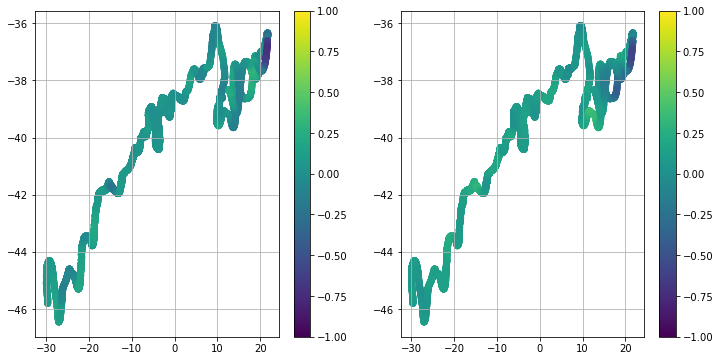

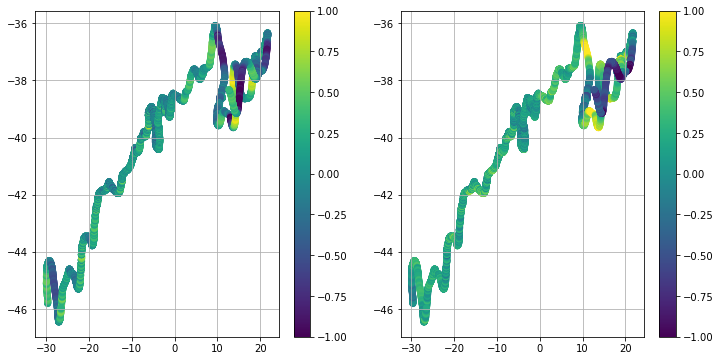

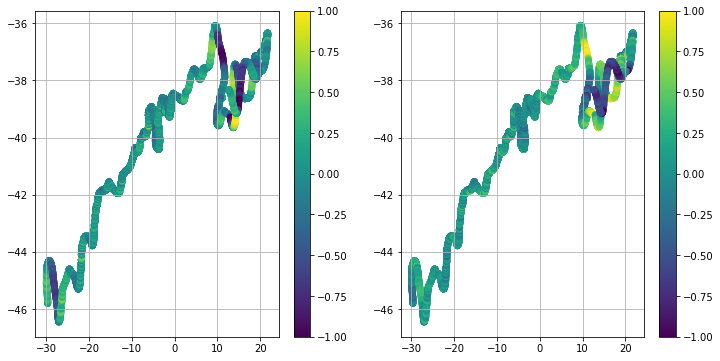

In [5]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.SSV_interp,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.SSU_interp,vmin=-1,vmax=1)
for a in ax:
    plt.colorbar(cs,ax=a)
    a.grid()
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.zonal_velocity,vmin=-1,vmax=1)
for a in ax:
    plt.colorbar(cs,ax=a)
    a.grid()
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity-df_tst.SSV_interp,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.zonal_velocity-df_tst.SSU_interp,vmin=-1,vmax=1)
for a in ax:
    plt.colorbar(cs,ax=a)
    a.grid()

Notes : 

First line : Eulerian mean field Interpolated over one drifter trajectory

Second line : Lagrangian velocity

Third line : Lagrangian velocity minus interpolated Eulerian mean field

### Visualization one partition : 

In [6]:
# Select 1 partition
df_part = df.get_partition(10).compute()


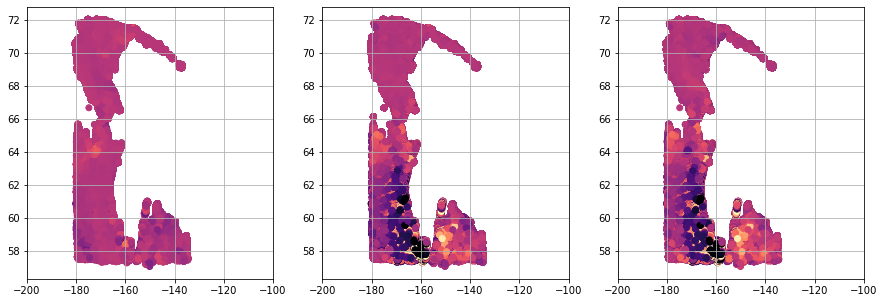

In [5]:
cmap= 'magma'

fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(df_part.lon,df_part.lat,c=df_part.SSU_interp,vmin=-1,vmax=1,cmap=cmap)
axs[0].set_xlim(-200,-100);axs[0].grid()

axs[1].scatter(df_part.lon,df_part.lat,c=df_part.zonal_velocity,vmin=-1,vmax=1,cmap=cmap)
axs[1].set_xlim(-200,-100);axs[1].grid()

axs[2].scatter(df_part.lon,df_part.lat,c=df_part.zonal_velocity-df_part.SSU_interp,vmin=-1,vmax=1,cmap=cmap)
axs[2].set_xlim(-200,-100);axs[2].grid()

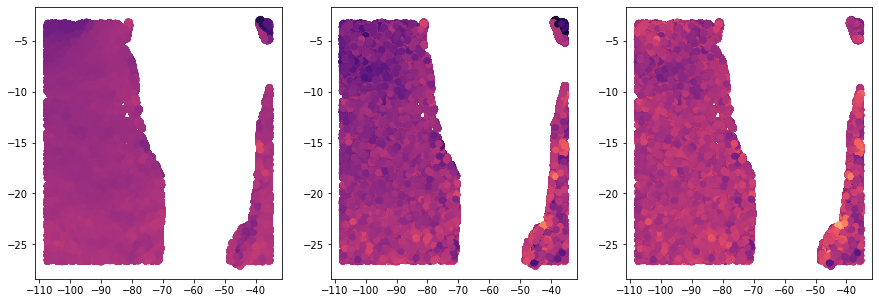

In [7]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(df_part.lon,df_part.lat,c=df_part.SSU_interp,vmin=-1,vmax=1,cmap=cmap)
#axs[0].set_xlim(-200,-100);axs[0].grid()

axs[1].scatter(df_part.lon,df_part.lat,c=df_part.zonal_velocity,vmin=-1,vmax=1,cmap=cmap)
#axs[1].set_xlim(-200,-100);axs[1].grid()

axs[2].scatter(df_part.lon,df_part.lat,c=df_part.zonal_velocity-df_part.SSU_interp,vmin=-1,vmax=1,cmap=cmap)
#axs[2].set_xlim(-200,-100);axs[2].grid()

#### Groupby means

In [4]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

In [5]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)

### Sub dataframe interpolated means and variables minus interpolated means

In [6]:
df = df.rename(columns={'SSU_interp':'zonal_velocity_interp','SSV_interp':'meridional_velocity_interp',
                        'Eta_interp':'sea_level_interp','SST_interp':'temperature_interp',
                       'SSS_interp':'salinity_interp'})

In [7]:
columns = df.columns[4:9]

for V in columns : 
    df[V] = df[V].sub(df[V+'_interp'])

In [8]:
# Add velocity amplitude in dataframe
df['velocity_amplitude'] = np.sqrt(df.zonal_velocity**2+df.meridional_velocity**2)
df['velocity_amplitude_interp'] = np.sqrt(df.zonal_velocity_interp**2+df.meridional_velocity_interp**2)

In [9]:
df = df.persist()

### Means computation

In [11]:
means = (df
         .groupby([df.lon_cut, df.lat_cut])
         .mean()
         .compute()
         #.to_frame()
        )



means = pa.add_geodata(means)
#count['density'] = count['count']/count['area']

ds_mean = (means
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [12]:
std = (df
         .groupby([df.lon_cut, df.lat_cut])
         .std()
         .compute()
         #.to_frame()
        )



std = pa.add_geodata(std)

ds_std = (std
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [13]:
ds_mean = ds_mean.rename({k :k+'_mean' for k in ds_mean.keys() })
ds_std = ds_std.rename({k :k+'_std' for k in ds_std.keys() })
ds_flts = xr.merge([ds_mean,ds_std])

In [30]:
count = (df
         .groupby([df.lon_cut, df.lat_cut])
         .count()
         .compute()
         #.to_frame()
        )

count = pa.add_geodata(count)

ds_count = (count.drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

ds_count = ds_count.trajectory#.rename({'trajectory':'count'})

ds_count.name = 'count'

In [32]:
ds_flts = xr.merge([ds_flts,ds_count])

In [33]:
ds_flts

<xarray.Dataset>
Dimensions:                          (lat: 179, lon: 359)
Coordinates:
  * lon                              (lon) float64 -179.5 -178.5 ... 177.5 178.5
  * lat                              (lat) float64 -89.5 -88.5 ... 87.5 88.5
Data variables:
    zonal_velocity_mean              (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_mean         (lon, lat) float64 nan nan nan ... nan nan
    sea_level_mean                   (lon, lat) float64 nan nan nan ... nan nan
    temperature_mean                 (lon, lat) float64 nan nan nan ... nan nan
    salinity_mean                    (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_interp_mean       (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_interp_mean  (lon, lat) float64 nan nan nan ... nan nan
    sea_level_interp_mean            (lon, lat) float64 nan nan nan ... nan nan
    salinity_interp_mean             (lon, lat) float64 nan nan nan ... nan nan
    temperature_interp_mean          (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_mean          (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_interp_mean   (lon, lat) float64 nan nan nan ... nan nan
    area_mean                        (lon, lat) float64 nan 49.22 ... 28.8 49.22
    zonal_velocity_std               (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_std          (lon, lat) float64 nan nan nan ... nan nan
    sea_level_std                    (lon, lat) float64 nan nan nan ... nan nan
    temperature_std                  (lon, lat) float64 nan nan nan ... nan nan
    salinity_std                     (lon, lat) float64 nan nan nan ... nan nan
    zonal_velocity_interp_std        (lon, lat) float64 nan nan nan ... nan nan
    meridional_velocity_interp_std   (lon, lat) float64 nan nan nan ... nan nan
    sea_level_interp_std             (lon, lat) float64 nan nan nan ... nan nan
    salinity_interp_std              (lon, lat) float64 nan nan nan ... nan nan
    temperature_interp_std           (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_std           (lon, lat) float64 nan nan nan ... nan nan
    velocity_amplitude_interp_std    (lon, lat) float64 nan nan nan ... nan nan
    area_std                         (lon, lat) float64 nan 49.22 ... 28.8 49.22
    count                            (lon, lat) float64 0.0 0.0 0.0 ... 0.0 0.0

### Visualization

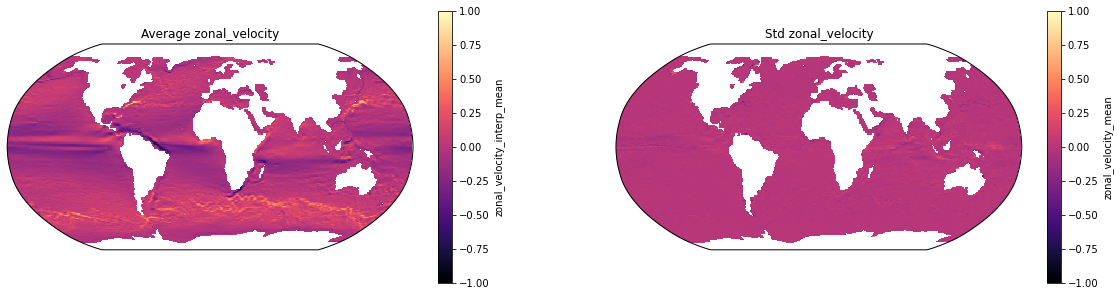

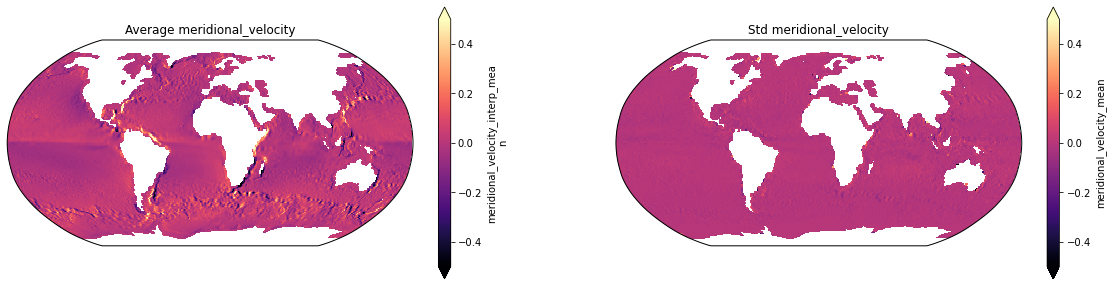

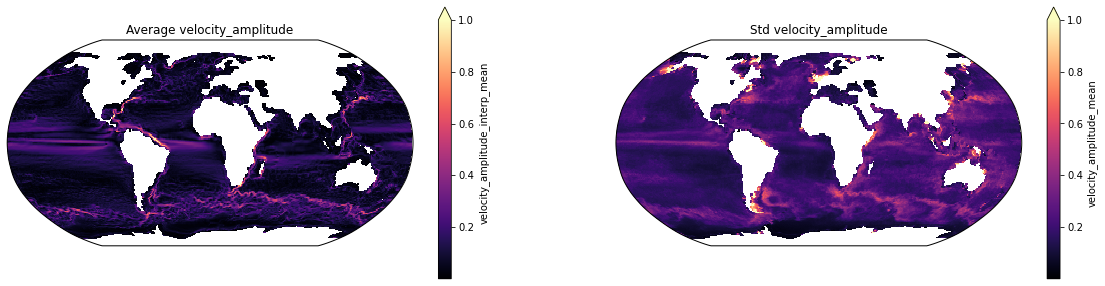

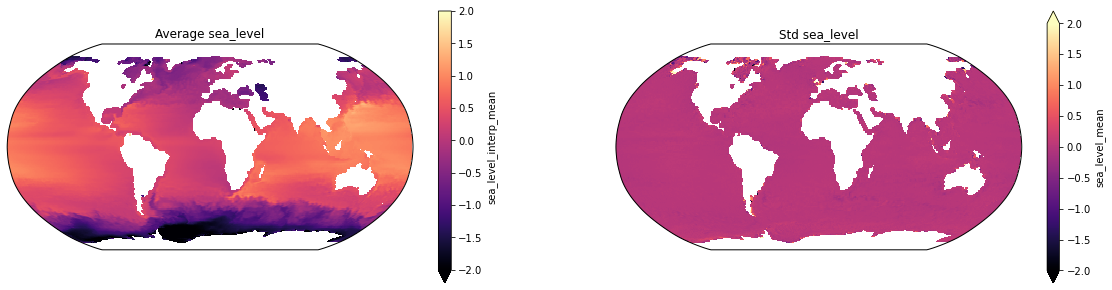

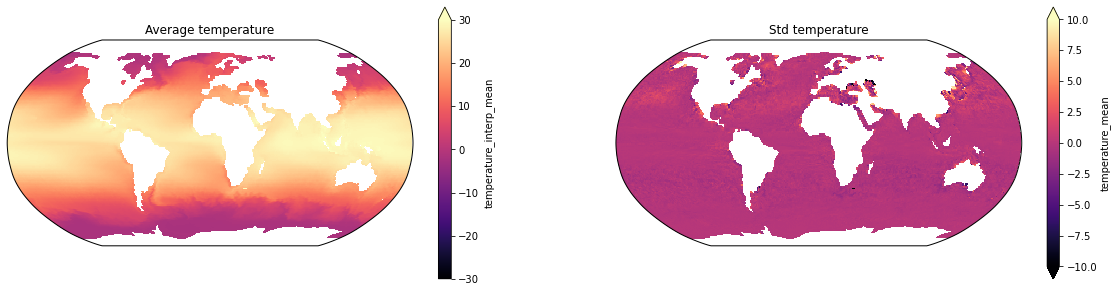

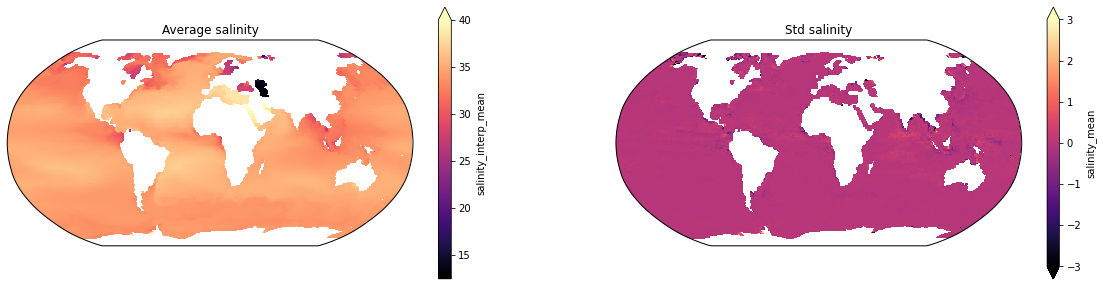

In [16]:
for V,vmax in zip(['zonal_velocity', 'meridional_velocity','velocity_amplitude','sea_level','temperature','salinity'],[[1,1],[0.5,0.5],[1,1],[2,2],[30,10],[40,3]]):
    figsize = (20,5)

    #crs = ccrs.Mollweide()
    crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection=crs)

    ds_flts[V+'_interp'+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[0],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Average '+V)
    ax = fig.add_subplot(122, projection=crs)

    ds_flts[V+'_mean'].plot(x='lon', 
                     y='lat',
                     vmax=vmax[1],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Std '+V)

In [21]:
# Drop useless columns
ds_flts = ds_flts.drop(['z_mean','z_std','trajectory_mean','trajectory_std'])

In [34]:
#store dataset in diagnostics directory
p.store_diagnostic("Linterp_mean_std_dl1", ds_flts,overwrite=True)

Linterp_mean_std_dl1 diagnostics stored in /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/Linterp_mean_std_dl1.zarr


### Binned mean (with time as index)

In [ ]:
group = ['lon_cut','lat_cut']
means = df.drop(columns=['sea_level','temperature','salinity']).groupby(group).transform('mean').persist()

In [ ]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], means, overwrite=True, name="time_binned_mean")

In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
